# Building and Training a Feedforward Neural Network for Language Modeling

This project explores the use of Feedforward Neural Networks (FNNs) in language modeling. The primary objective is to build a neural network that learns word relationships and generates meaningful text sequences. The implementation is done using PyTorch, covering key aspects of Natural Language Processing (NLP), such as:
* Tokenization & Indexing: Converting text into numerical representations.
* Embedding Layers: Mapping words to dense vector representations for efficient learning.
* Context-Target Pair Generation (N-grams): Structuring training data for sequence prediction.
* Multi-Class Neural Network: Designing a model to predict the next word in a sequence.

The training process includes optimizing the model with loss functions and backpropagation techniques to improve accuracy and coherence in text generation. By the end of the project, you will have a working FNN-based language model capable of generating text sequences.


FNNs, or Multi-Layer Perceptrons, serve as the foundational components for comprehending neural networks in natural language processing (NLP). In NLP tasks, FNNs process textual data by transforming it into numerical vectors known as embeddings. Subsequently, these embeddings are input to the network to predict language facets, such as the upcoming word in a sentence or the sentiment of a text.

Let's consider the following song lyrics for our analysis.


In [20]:
import warnings
from tqdm import tqdm

warnings.simplefilter('ignore')
import time
from collections import OrderedDict

import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import string
import time
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from nltk.tokenize import word_tokenize

from sklearn.manifold import TSNE

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/victorcata/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/victorcata/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Dataset

In [2]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

## Data preprocessing

In [3]:
def preprocess_string(s):
  """
  Preprocesses a given string by performing the following steps:
  
  1. Removes all non-word characters (excluding letters and numbers).
  2. Removes all whitespace characters.
  3. Removes all numeric digits.

  Parameters:
  s (str): The input string to be cleaned.

  Returns:
  str: The processed string with only alphabetic characters, no spaces, and no digits.
  """

  s = re.sub(r"[^\w\s]", '', s)
  s = re.sub(r"\s+", '', s)
  s = re.sub(r"\d", '', s)

  return s

In [4]:
def preprocess(words):
  """
  Preprocesses a given text by tokenizing it, cleaning individual words, and 
  converting them to lowercase while removing empty or punctuation tokens.

  Steps:
  1. Tokenization: Splits the input text into individual word tokens.
  2. Cleaning: Applies `preprocess_string()` to remove non-word characters, 
      spaces, and digits from each token.
  3. Normalization: Converts all tokens to lowercase.
  4. Filtering: Removes empty strings and punctuation tokens.

  Parameters:
  words (str): The input text to be tokenized and preprocessed.

  Returns:
  list: A list of cleaned, lowercase tokens.
  """
  tokens = word_tokenize(words)
  tokens = [preprocess_string(w) for w in tokens]
  return [w.lower() for w in tokens if len(w) != 0 and w not in string.punctuation]

## Tokenization and Indexing

In [5]:
tokenizer = get_tokenizer('basic_english')
tokens = tokenizer(song)

In [6]:
def tokenizetext(song):
  """
  Tokenizes the input text (song) and builds a vocabulary from the tokens.

  Steps:
  1. Tokenization: The function splits the input text into words and applies 
      a tokenizer function to each word.
  2. Vocabulary Building: Constructs a vocabulary from the tokenized words,
      including a special "<unk>" token to handle out-of-vocabulary words.
  3. Default Indexing: Sets the default index for unknown words, ensuring 
      that any unseen tokens are mapped to "<unk>".

  Parameters:
  song (str): The input text (song lyrics) to be tokenized and processed.

  Returns:
  vocab (Vocab): A vocabulary object mapping tokens to their corresponding indices.
  """
  tokenized_song = map(tokenizer, song.split())
  vocab = build_vocab_from_iterator(tokenized_song, specials=['<unk>'])
  vocab.set_default_index(vocab['<unk>'])

  return vocab



In [8]:
vocab = tokenizetext(song)
print(tokens[0:10])
vocab(tokens[0:10])

['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules']


[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

In [9]:
text_pipeline = lambda x: vocab(tokenizer(x))
text_pipeline(song)[0:10]

[21, 58, 70, 74, 25, 69, 2, 20, 31, 72]

In [10]:
index_to_token = vocab.get_itos()
index_to_token[58]

'are'

## Generating context-target pairs (n-grams)

Organize words within a variable-size context using the following approach: Each word is denoted by 'i'. 
To establish the context, simply subtract 'j'. The size of the context is determined by the value of``CONTEXT_SIZE``.

In [14]:
CONTEXT_SIZE = 2

def genngrams(tokens):
  """
  Generates n-grams from a list of tokens, where each n-gram consists of a 
  context (previous words) and a target (next word).

  The function constructs a list of tuples where:
  - The first element is a list of `CONTEXT_SIZE` previous words.
  - The second element is the target word that follows the context.

  Parameters:
  tokens (list): A list of preprocessed word tokens.

  Returns:
  list: A list of tuples representing n-grams.
        Each tuple contains (context_words, target_word).
  """
  ngrams = [
    (
      [tokens[i - j - 1] for j in range(CONTEXT_SIZE)],
      tokens[i]
    )
    for i in range(CONTEXT_SIZE, len(tokens))
  ]

  return ngrams


In [ ]:
ngrams = genngrams(tokens)
context, target = ngrams[0]
print(f"Context: {context}, Target: {target}")
print(f"Context index {vocab(context)}, Target index: {vocab([target])}")

Context: ['are', 'we'], Target: no
Context index [58, 21], Target index: [70]


## Embedding layers

An embedding layer is a crucial element in natural language processing (NLP) and neural networks designed for sequential data. It serves to convert categorical variables, like words or discrete indexes representing tokens, into continuous vectors. This transformation facilitates training and enables the network to learn meaningful relationships among words.

In [11]:
def genembedding(vocab):
  """
  Generates an embedding layer for the given vocabulary.

  The embedding layer transforms words into dense vector representations, 
  allowing the model to learn semantic relationships between words.

  Parameters:
  vocab (Vocab): The vocabulary object containing unique words and their indices.

  Returns:
  nn.Embedding: A PyTorch embedding layer with a specified embedding dimension.
  """
  embedding_dim = 20
  vocab_size = len(vocab)
  embeddings = nn.Embedding(vocab_size, embedding_dim)

  return embeddings

Obtain the embedding for the first word with index 0 or 1. Don't forget that you have to convert the input into a tensor. The embeddings are initially initialized randomly, but as the model undergoes training, words with similar meanings gradually come to cluster closer together

In [13]:
embeddings = genembedding(vocab)
for n in range(2):
  embedding = embeddings(torch.tensor(n))
  print("Word:",index_to_token[n])
  print("Index:",n)
  print( "Embedding:", embedding)
  print("Embedding shape:", embedding.shape)



Word: <unk>
Index: 0
Embedding: tensor([-0.6354, -0.2197,  0.8491,  0.1431, -2.2938, -1.8163,  0.1331,  0.0476,
        -0.7577, -1.4908,  1.3110,  0.3879,  0.8222, -0.1266,  0.5712,  1.3758,
         0.1485,  0.6107,  0.7573, -1.2085], grad_fn=<EmbeddingBackward0>)
Embedding shape: torch.Size([20])
Word: gonna
Index: 1
Embedding: tensor([-0.2112, -0.0594, -1.7269, -1.0018,  1.6897,  0.8871, -0.6761,  1.2268,
         0.4421,  0.0943,  0.2007, -0.7764,  0.6807,  0.5567,  1.4730,  0.3976,
        -2.1650,  0.6482,  0.4216,  1.1344], grad_fn=<EmbeddingBackward0>)
Embedding shape: torch.Size([20])


## Building the Context Vector

In [17]:
embedding_dim = 20
linear = nn.Linear(embedding_dim * CONTEXT_SIZE, 128)

embeddings = genembedding(vocab)
my_embeddings = embeddings(torch.tensor(vocab(context)))
my_embeddings.shape


torch.Size([2, 20])

In [18]:
my_embeddings = my_embeddings.reshape(1, -1)
my_embeddings.shape

torch.Size([1, 40])

In [19]:
linear(my_embeddings)

tensor([[-4.8589e-02,  4.6554e-01,  4.4658e-02, -5.4018e-01,  4.9972e-01,
          2.2336e-02,  1.0005e+00, -2.3656e-01, -7.8520e-01,  4.3643e-01,
         -2.1531e-01,  4.5250e-01,  1.3677e-01, -2.4120e-01,  8.2444e-01,
         -1.0938e-01,  4.1674e-01, -7.1123e-01, -3.4872e-01, -1.6817e-01,
         -1.3821e+00, -7.1429e-01, -5.4796e-01,  8.2348e-01, -7.2317e-01,
         -2.3837e-01,  7.1665e-01,  3.5728e-01,  2.9353e-01,  9.0465e-01,
         -2.5045e-01,  2.6704e-01, -2.8450e-02, -2.7208e-01, -2.2629e-01,
          2.8039e-02, -3.7449e-01,  3.3556e-01,  3.0679e-01, -1.0667e-01,
         -8.8807e-02, -2.1987e-01, -2.9507e-02,  4.4298e-01, -6.1503e-01,
          1.0806e-03, -5.1298e-03,  3.8995e-01, -9.6559e-01,  4.9574e-01,
          4.8145e-01, -5.9496e-01, -1.6780e+00,  1.4674e+00,  1.7029e-01,
          9.5823e-01, -9.0435e-01,  2.2929e-01, -7.2717e-01,  8.3934e-01,
         -1.7391e-01,  5.4527e-01,  8.2080e-02, -9.9844e-01, -6.1184e-01,
          1.3546e-01, -1.1739e-01, -2.

## Batch function and Data Loader

Create a Batch function to interface with the data loader. Several adjustments are necessary to handle words that are part of a context in one batch and a predicted word in the following batch.

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CONTEXT_SIZE = 3
BATCH_SIZE = 10
EMBEDDING_DIM = 10

def collate_fn(batch):
  """
  Processes a batch of text data into input (context) and output (target) tensors
  for training a language model.

  The function extracts:
  - `context`: A list of word indices representing the context words for each target word.
  - `target`: A list of word indices representing the target word to predict.

  Parameters:
  batch (list): A list of tokenized words (strings).

  Returns:
  tuple: Two PyTorch tensors: (context_tensor, target_tensor)
          - context_tensor: Tensor of shape (batch_size - CONTEXT_SIZE, CONTEXT_SIZE),
            containing the word indices of context words.
          - target_tensor: Tensor of shape (batch_size - CONTEXT_SIZE,),
            containing the word indices of target words.
  """
  batch_size = len(batch)
  context, target = [], []

  for i in range(CONTEXT_SIZE, batch_size):
    target.append(vocab([batch[i]]))
    context.append(vocab([batch[i - j - 1] for j in range(CONTEXT_SIZE)]))

  return torch.tensor(context).to(device), torch.tensor(target).to(device).reshape(-1)

Similarly, it's important to highlight that the size of the last batch could deviate from that of the earlier batches. To tackle this, the approach involves adjusting the final batch to conform to the specified batch size, ensuring it becomes a multiple of the predetermined size. When necessary, you'll employ padding techniques to achieve this harmonization. One approach you'll use is appending the beginning of the song to the end of the batch.

In [23]:
padding = BATCH_SIZE - len(tokens) % BATCH_SIZE
tokens_pad = tokens + tokens[0:padding]

dataloader = DataLoader(
  tokens_pad,
  batch_size=BATCH_SIZE,
  shuffle=False,
  collate_fn=collate_fn
)

## Multi-class neural network

The network's output is the probability of the next word within a given context. Therefore, the number of classes corresponds to the count of distinct words. The initial layer consists of embeddings, and in addition to the final layer, an extra hidden layer is incorporated.

In [24]:
class NGramLanguageModeler(nn.Module):
  """
  A neural network-based n-gram language model that predicts the next word 
  given a sequence of context words.

  This model consists of:
  - An embedding layer that converts word indices into dense vector representations.
  - A fully connected hidden layer with ReLU activation.
  - An output layer that predicts the probability distribution over the vocabulary.

  Parameters:
  vocab_size (int): The number of unique words in the vocabulary.
  embedding_dim (int): The size of the word embeddings (vector representation of words).
  context_size (int): The number of previous words used as context to predict the next word.
  """
  def __init__(self, vocab_size, embedding_dim, context_size):
    super(NGramLanguageModeler, self).__init__()

    self.context_size = context_size
    self.embedding_dim = embedding_dim

    # Embedding layer: Maps word indices to dense vectors
    self.embeddings = nn.Embedding(vocab_size, embedding_dim)

    # Fully connected hidden layer: Maps the concatenated embeddings to a 128-dim space
    self.linear1 = nn.Linear(context_size * embedding_dim, 128)

    # Output layer: Maps the hidden layer output to vocabulary size (probability distribution over words)
    self.linear2 = nn.Linear(128, vocab_size)

  def forward(self, inputs):
      """
      Forward pass of the model.

      Parameters:
      inputs (Tensor): A tensor of shape (batch_size, context_size) containing word indices.

      Returns:
      Tensor: A tensor of shape (batch_size, vocab_size) representing predicted probabilities for the next word.
      """
      embeds = self.embeddings(inputs)
      embeds = torch.reshape(embeds, (-1, self.context_size * self.embedding_dim))
      out = F.relu(self.linear1(embeds))
      out = self.linear2(out)

      return out


In [33]:
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)

context, target = next(iter(dataloader))
print(context, target)
out = model(context)
print(out.shape)

tensor([[70, 58, 21],
        [74, 70, 58],
        [25, 74, 70],
        [69, 25, 74],
        [ 2, 69, 25],
        [20,  2, 69],
        [31, 20,  2]]) tensor([74, 25, 69,  2, 20, 31, 72])
torch.Size([7, 79])


While the model remains untrained, analyzing the output can provide us with a clearer understanding. In the output, the first dimension corresponds to the batch size, while the second dimension represents the probability associated with each class.

In [35]:
predicted_index =torch.argmax(out,1)
print(predicted_index)
[index_to_token[i.item()] for i in  predicted_index]

tensor([ 9, 31, 42, 72, 39, 63, 40])


['around', 'the', 'hearts', 'rules', 'game', 'dont', 'going']

In [37]:
def write_song(model, my_song, number_of_words=100):
  """
  Generates text using a trained n-gram language model.

  Given an initial text (`my_song`), the function generates additional words by 
  predicting the next word iteratively based on the trained model.

  Parameters:
  model (nn.Module): The trained n-gram language model.
  my_song (str): The initial seed text to start generating words.
  number_of_words (int): The number of words to generate (default: 100).

  Returns:
  str: The generated song lyrics as a string.
  """
  index_to_token = vocab.get_itos()

  for i in range(number_of_words):
    with torch.no_grad():
      # Prepare the input context by extracting the last CONTEXT_SIZE words from tokens
      context = torch.tensor(
          vocab([tokens[i - j - 1] for j in range(CONTEXT_SIZE)])
      ).to(device)
      
      word_idx = torch.argmax(model(context))
      
      my_song += " " + index_to_token[word_idx.detach().item()]

  return my_song

In [38]:
def pickrandomline(song):
  """
  Selects a random line from the given song text.
  This function splits the song into separate lines and randomly picks one of them.
  Parameters:
  song (str): The song lyrics as a multi-line string.
  Returns:
  str: A randomly selected line from the song.
  """
  # Split the song into individual lines
  lines = song.split("\n")    
  # Randomly select a line and remove leading/trailing whitespace
  selected_line = random.choice(lines).strip()
  
  return selected_line

In [39]:
selected_line = pickrandomline(song)
generated_song = write_song(model, selected_line)
print(generated_song)

Never gonna make you cry around rules are around the hearts rules game dont going rules rules too shy dont if going rules gonna gonna the gonna around dont game rules gonna rules shy it the game never rules gonna dont lie the gonna gonna desert what shy give get game rules whats shy are make long know if make give do you around your shy it give rules what you dont what desert give me dont going make hearts around say shy going rules around get shy blind game gonna the im it going rules we rules thinking wanna do each too game rules


## Training

Training a language model involves a multi-step process that leverages training and testing data to optimize model performance. In the realm of Natural Language Processing (NLP), this process often employs various metrics to gauge a model's accuracy, such as perplexity or accuracy on unseen data. However, in the context of your current exploration, you will embark on a slightly different journey. Instead of relying solely on conventional NLP metrics, the focus shifts to manual inspection of the results. 

In [40]:
criterion = torch.nn.CrossEntropyLoss()

In [41]:
def train(dataloader, model, song, number_of_epochs=100, show=10):
  """
  Args:
    dataloader (DataLoader): DataLoader containing training data.
    model (nn.Module): Neural network model to be trained.
    number_of_epochs (int, optional): Number of epochs for training. Default is 100.
    show (int, optional): Interval for displaying progress. Default is 10.
  Returns:
    list: List containing loss values for each epoch.
  """
  MY_LOSS = []  # List to store loss values for each epoch

  
  for epoch in tqdm(range(number_of_epochs)):
    total_loss = 0 
    my_song = ""

    for context, target in dataloader:
      model.zero_grad()
      predicted = model(context)
      loss = criterion(predicted, target.reshape(-1))
      total_loss += loss.item()

      loss.backward()
      optimizer.step()

    # Display progress and generate song at specified intervals
    if epoch % show == 0:
      selected_line = pickrandomline(song)
      my_song += write_song(model, selected_line)

      print("Generated Song:")
      print("\n")
      print(my_song)

    MY_LOSS.append(total_loss/len(dataloader)) 

  return MY_LOSS

### For a context of 2

In [42]:
my_loss_list = []
CONTEXT_SIZE = 2

model_2 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_2.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1.0, gamma=0.1)

my_loss = train(dataloader, model_2, song)

 15%|█▌        | 15/100 [00:00<00:01, 78.45it/s]

Generated Song:


Never gonna let you down never hurt each give you you and never too never around you and commitments we around guy never and guy give around give around give for for around what and strangers around you around give for and never never hurt never hurt gonna never for never gonna gonna never we never commitments gonna never for and you give never gonna never for never gonna gonna never for give gonna never around it for around around never never for around never never and guy guy and guy around never you and for you get and thinking around hurt you you strangers
Generated Song:


Never gonna say goodbye never never gonna you you you you never never you you you you you you you you never you you you you never gonna you you and you never you you you gonna you never never you never never you never never gonna tell you never never gonna tell you never never gonna tell around and you you never gonna tell you never never gonna tell you never gonna tell you you you you you neve

 48%|████▊     | 48/100 [00:00<00:00, 102.50it/s]

Generated Song:


Never gonna make you cry never never gonna you you you you never never you you hurt you tell you down you never you you you you down gonna desert been and and and you to you tell you down you feeling never never you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell you never gonna tell a lie and hurt you never never and you hurt never and and gonna been you but you never gonna to you never you we both know you you never
Generated Song:


Never gonna make you cry never never no strangers to love you never never been you desert you tell you lie you never you you you you how gonna desert been and other and you to you tell you how im feeling never never you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never never and you for never and and gonna been aching 

 81%|████████  | 81/100 [00:00<00:00, 94.20it/s] 

Generated Song:


Never gonna let you down never known no strangers to love you cry the game and desert you i a lie strangers never you you you you how and this been and other how you to to tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never known each other for you and and hearts been aching but youre never shy to love never inside we both know whats been going
Generated Song:


Never gonna say goodbye never are no strangers to love you know the game and were you i a lie strangers never im feeling you you how and this been and other how you to to tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never known each other for you and i hearts been aching 

100%|██████████| 100/100 [00:01<00:00, 92.71it/s]

Generated Song:


Your hearts been aching but youre too shy to say it never are no strangers to love you know the game and were you i a full strangers never im feeling the you how get this from and other how you to to tell you how im feeling gotta make you cry never gonna tell you up never gonna tell you down never gonna tell around and desert you never gonna tell you cry never gonna tell goodbye never gonna tell a lie and hurt you never known each other for you and i hearts been aching but youre too shy to love never inside we both know whats been going


In [43]:
save_path = 'models/2gram.pth'
torch.save(model_2.state_dict(), save_path)
my_loss_list.append(my_loss)


The code provided below shows word embeddings from the created model, reduces their dimensionality to 2D using t-SNE, and then plots them as a scatter plot. Additionally, it annotates the first 20 points in the visualization with their corresponding words. This is used to visualize how similar words cluster together in a lower-dimensional space, revealing the structure of the word embeddings. Embeddings allow the model to represent words in a continuous vector space, capturing semantic relationships and similarities between words.

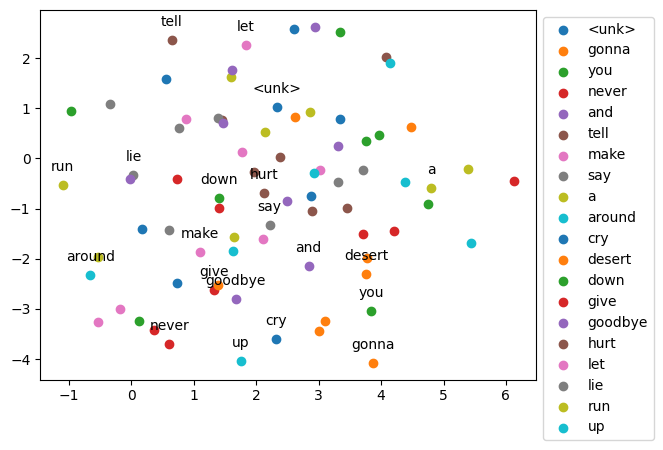

In [ ]:
X = model_2.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
  if j < 20:
    plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
    labels.append(index_to_token[j])
    # Add words as annotations
    plt.annotate(index_to_token[j],
                  (X_2d[j, 0], X_2d[j, 1]),
                  textcoords="offset points",
                  xytext=(0, 10),
                  ha='center')
  else:
    plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### For a context of 4

In [45]:
CONTEXT_SIZE=4
model_4 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_4.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_4,song)

save_path = 'models/4gram.pth'
torch.save(model_4.state_dict(), save_path)

my_loss_list.append(my_loss)

 21%|██        | 21/100 [00:00<00:00, 101.43it/s]

Generated Song:


A full commitments what Im thinking of give never up you know up cry are know i are cry this for cry other never up you you but other never never never guy on never and other tell you any you up never up cry other are never up gonna up you hurt never gonna your you you never gonna up you run you you never gonna lie you up up gonna up other down your your you you never up you give never up gonna know other this other up cry are your up are are up up cry never up give cry gotta never up
Generated Song:


Inside we both know whats been going on never never gonna you gonna you you never never never you you you never gonna you never never you you gonna gonna never never gonna you never never never gonna gonna you you you you never gonna you you you never you gonna gonna you never never gonna let you you never gonna gonna you and you you never gonna make you never never gonna gonna you never gonna tell you you never never you never never gonna gonna never you gonna you you 

 43%|████▎     | 43/100 [00:00<00:00, 103.72it/s]

Generated Song:


Never gonna say goodbye never never gonna you to and you down never never and you desert never a you never never you you never never down never gonna let make never and gonna and you and you how im feeling gotta make you never never gonna say you up never gonna let you down never gonna say around and desert you never gonna make you up never gonna say goodbye never gonna tell a lie and hurt you never known each other for never make you you you aching but youre too shy to never you never and both know whats been going
Generated Song:


Your hearts been aching but youre too shy to say it never known gonna whats to love you know never never and you gonna never a you never never you you never never down never gonna let any never and i and you and a how im feeling gotta make you up never gonna say you up never gonna let you down never gonna say around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other f

 76%|███████▌  | 76/100 [00:00<00:00, 101.30it/s]

Generated Song:


Never gonna tell a lie and hurt you never are no strangers to love you know never rules im were gonna never a full commitments what im you never never down never this from any other guy i tell you and a how im feeling gotta make you up never gonna say you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so make you never been aching but youre too shy to and goodbye never we both know whats been going
Generated Song:


Never gonna say goodbye never are no strangers to love you know the rules im were gonna never a full commitments what im you cry never down never this from any other guy i tell and and a how im feeling gotta make you up never gonna say you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so make you n

 87%|████████▋ | 87/100 [00:00<00:00, 75.65it/s] 

Generated Song:


You know the rules and so do I never are no strangers to love you know the rules im were i play a full commitments what im thinking cry never down never this from any other guy i tell and play a how im feeling gotta make you up the gonna run you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so make you never been aching but youre too shy to see goodbye never we both know whats been going
Generated Song:


Never gonna say goodbye never are no strangers to love you know the rules im were i play a full commitments what im thinking cry never know never this from any other guy i tell and play a how im feeling gotta make you cry the gonna run you up never gonna let you down never gonna run around and desert you never gonna make you cry never gonna say goodbye never gonna tell a lie and hurt you never known each other for so make you never been 

100%|██████████| 100/100 [00:01<00:00, 87.04it/s]


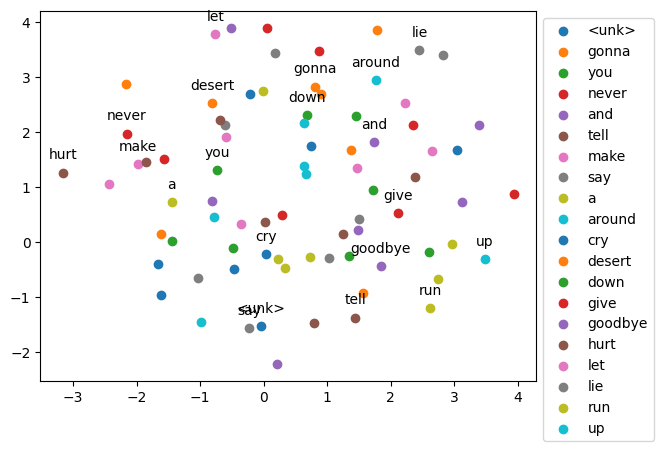

In [47]:
X = model_4.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
  if j < 20:
    plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
    labels.append(index_to_token[j])
    # Add words as annotations
    plt.annotate(index_to_token[j],
                  (X_2d[j, 0], X_2d[j, 1]),
                  textcoords="offset points",
                  xytext=(0, 10),
                  ha='center')
  else:
    plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### For a context of 8

In [50]:
CONTEXT_SIZE=8
model_8 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)
optimizer = optim.SGD(model_8.parameters(), lr=0.01)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
my_loss=train(dataloader,model_8,song)

save_path = 'models/8gram.pth'
torch.save(model_8.state_dict(), save_path)

my_loss_list.append(my_loss)

 10%|█         | 10/100 [00:00<00:01, 49.70it/s]

Generated Song:


Never gonna say goodbye never do you me from been you cry tell a and down it tell you down love you im you around down do desert tell you ask long game you you you on never never you tell lie it you gotta but down never any down down down let you down long tell you you down see tell never gonna you you down down down tell you down down tell a tell been do you never love down so you down long give you too down weve the you it down you down never ask you you love down down
Generated Song:


Never gonna tell a lie and hurt you never never tell you for love you you the gonna you make you never you down never gonna im you you make you gonna tell you make you guy you you you you never never you make you make you never never gonna never you down gonna gonna let you down never gonna let around down never you never gonna make you down never gonna never around down gonna tell a lie never tell you never you gonna you for you gonna never make you you you never you shy never you g

 37%|███▋      | 37/100 [00:00<00:00, 76.70it/s]

Generated Song:


Never gonna give you up never never tell you for love you tell the rules other make you never you i never never im thinking you make you gonna rules you make you guy i you you you never never you make you make you never never gonna say make down never gonna let you down never gonna run around and never tell never gonna make you up never gonna say around down gonna tell a lie never hurt you never you gonna other for so gonna never make you going you tell too shy to you i never make you you never been going
Generated Song:


Never gonna tell a lie and hurt you never never rules other for love you tell the rules other make you never you i never never im thinking you make you the play you make you guy i you you you never never you make you make you never never gonna say make down never gonna let you down never gonna run around and never tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you gonna other for so gonna give make you 

 54%|█████▍    | 54/100 [00:00<00:00, 79.61it/s]

Generated Song:


Never gonna run around and desert you never never rules other for love you tell the rules i make you never you i never never im thinking you make you the play you make you guy i i you you never never rules make you make you never never gonna say make down never gonna let you down never gonna run around and never tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you gonna other for so gonna give make you going you tell too shy to it i im thinking you you love been going
Generated Song:


Weve known each other for so long never never rules other for love you tell the rules i make you never you i never never im thinking you make you the play you make you guy i i you you never never rules make you make you never never gonna say make down never gonna let you down never gonna run around and never tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you gonna other for so gonna give make you

 72%|███████▏  | 72/100 [00:00<00:00, 83.36it/s]

Generated Song:


Never gonna tell a lie and hurt you never never rules other for love you tell the rules i make you never you i never never im thinking you make you the play you make you guy i i you you never never rules make you make you never never gonna say make down never gonna let you down never gonna run around and never tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you rules other for so gonna give make you going you tell too shy to it i im thinking make you to been going
Generated Song:


Never gonna let you down never im rules other for love you tell the rules i make you never you i never never im thinking you make you the play on make you guy i i you you never never rules make you make you never never gonna say make down never gonna let you down never gonna run around and never tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you rules other for so gonna give make say going you tell 

 91%|█████████ | 91/100 [00:01<00:00, 87.16it/s]

Generated Song:


Inside we both know whats been going on never im rules other for love you tell the rules i make you never you i never never im thinking you make you the play on make you guy i i you you never never rules make you make you never tell gonna say make down never gonna let you down never gonna run around and never tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you rules other for so gonna give make say going you tell too shy to it i im thinking make you to been going
Generated Song:


Never gonna give you up never im rules other for love you tell the rules i make you never you i never never im thinking you make you the play on make you guy i i you you never never rules make you make you never tell gonna say make down never gonna let you down never gonna run around and never tell never gonna make you up never gonna say around and gonna tell a lie never hurt you never you rules other for so gonna give make say going you tell too

100%|██████████| 100/100 [00:01<00:00, 78.09it/s]


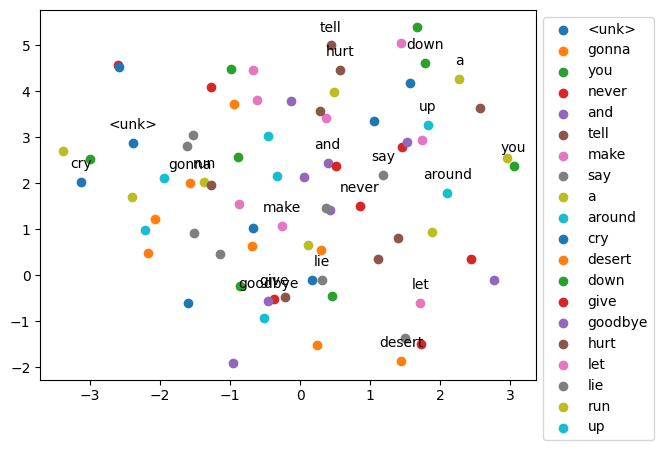

In [49]:
X = model_8.embeddings.weight.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

labels = []

for j in range(len(X_2d)):
  if j < 20:
    plt.scatter(X_2d[j, 0], X_2d[j, 1], label=index_to_token[j])
    labels.append(index_to_token[j])
    # Add words as annotations
    plt.annotate(index_to_token[j],
                  (X_2d[j, 0], X_2d[j, 1]),
                  textcoords="offset points",
                  xytext=(0, 10),
                  ha='center')
  else:
    plt.scatter(X_2d[j, 0], X_2d[j, 1])

plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

### Loss analysis

When considering the plotted loss for each model, a discernible trend emerges: an increase in context size correlates with a reduction in loss. While this specific approach lacks the inclusion of model validation or the utilization of conventional NLP evaluation metrics, the visual evidence substantiates its superior performance.

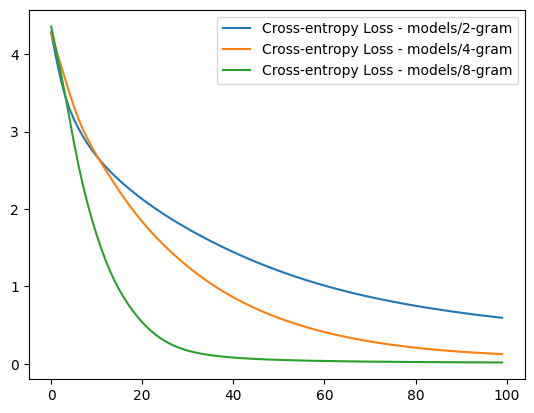

In [51]:
for (my_loss, model_name)in zip(my_loss_list,["models/2-gram","models/4-gram","models/8-gram"]):
  plt.plot(my_loss,label="Cross-entropy Loss - {}".format(model_name))
  plt.legend()

## Perplexity

Perplexity is a measurement used to evaluate the effectiveness of language models or probability models. It provides an indication of how well a model predicts a sample of data or the likelihood of an unseen event. Perplexity is commonly used in natural language processing tasks, such as machine translation, speech recognition, and language generation.

Perplexity is derived from the concept of cross-entropy loss, which measures the dissimilarity between predicted probabilities and actual probabilities. 

$$\text{Cross-Entropy Loss} = -\sum_{i=1}^{N} y_i \ln(p_i)$$
The cross-entropy loss is calculated by taking the negative sum of the products of the true labels $y_i$ and the logarithm of the predicted probabilities $p_i$ over $N$ classes.

Taking the exponential of the mean cross-entropy loss gives us the perplexity value.

$$\text{Perplexity} = e^{\frac{1}{N} \text{Cross-Entropy Loss}}$$


A lower perplexity value indicates that the model is more confident and accurate in predicting the data. Conversely, a higher perplexity suggests that the model is less certain and less accurate in its predictions.

Perplexity can be seen as an estimate of the average number of choices the model has for the next word or event in a sequence. A lower perplexity means that the model is more certain about the next word, while a higher perplexity means that there are more possible choices.


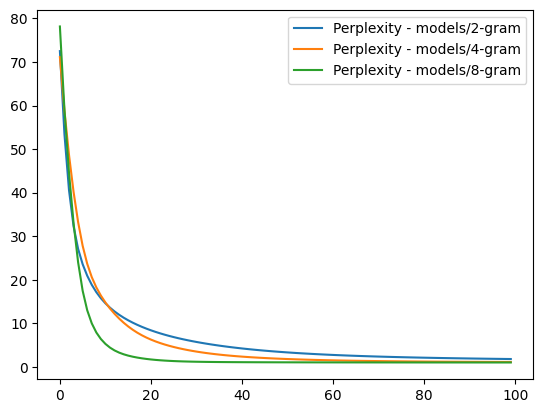

In [52]:
for (my_loss, model_name)in zip(my_loss_list,["models/2-gram","models/4-gram","models/8-gram"]):
    # Calculate perplexity using the loss
  perplexity = np.exp(my_loss)
  plt.plot(perplexity,label="Perplexity - {}".format(model_name))
  plt.legend()

## Exercise 1

Source a collection of nursery rhymes and compile them into a single text variable.

In [54]:
nursery_rhymes = """
Little Miss Muffet
Sat on a tuffet,
Eating her curds and whey;
Along came a spider
Who sat down beside her
And frightened Miss Muffet away.

Twinkle, twinkle, little star,
How I wonder what you are!
Up above the world so high,
Like a diamond in the sky.

Baa, baa, black sheep,
Have you any wool?
Yes sir, yes sir,
Three bags full.

Jack and Jill went up the hill
To fetch a pail of water.
Jack fell down and broke his crown,
And Jill came tumbling after.

Hickory dickory dock,
The mouse ran up the clock.
The clock struck one,
The mouse ran down,
Hickory dickory dock.

Humpty Dumpty sat on a wall,
Humpty Dumpty had a great fall.
All the king's horses and all the king's men
Couldn't put Humpty together again.

Mary had a little lamb,
Its fleece was white as snow;
And everywhere that Mary went,
The lamb was sure to go.

Old MacDonald had a farm,
E-I-E-I-O,
And on his farm he had a cow,
E-I-E-I-O.

Itsy Bitsy Spider climbed up the waterspout.
Down came the rain and washed the spider out.
Out came the sun and dried up all the rain,
And the Itsy Bitsy Spider climbed up the spout again.

The wheels on the bus go round and round,
Round and round,
Round and round.
The wheels on the bus go round and round,
All through the town.
"""

## Exercise 2

Preprocess the text data to tokenize and create n-grams

In [56]:
N = 2
tokens = preprocess(nursery_rhymes)
ngrams = genngrams(tokens)
context, target = ngrams[0]
print(context, target)

['eating', 'tuffet', 'a', 'on', 'sat', 'muffet', 'miss', 'little'] her


## Exercise 3

Convert Context Words into Embeddings and Pass Them Through a Linear Layer

In [57]:
embedding_dim = 20  # Each word will be represented as a 20-dimensional vector

vocab = tokenizetext(nursery_rhymes)  
linear = nn.Linear(embedding_dim * CONTEXT_SIZE, 128)  

embeddings = genembedding(vocab)  
my_embeddings = embeddings(torch.tensor(vocab(context)))
my_embeddings = my_embeddings.reshape(1, -1)  

output = linear(my_embeddings)  
print("Output shape:", output.shape)  

Output shape: torch.Size([1, 128])


## Exercise 4

Implement Batch Processing with Padding for Language Modeling

In [58]:
CONTEXT_SIZE = 3
BATCH_SIZE = 10
EMBEDDING_DIM = 10

padding = BATCH_SIZE - len(tokens) % BATCH_SIZE  
tokens_pad = tokens + tokens[0:padding]  

dataloader = DataLoader(
    tokens_pad, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
)  

print(f"Total tokens (after padding): {len(tokens_pad)}")


Total tokens (after padding): 240


## Exercise 5

Train an N-gram language model using the provided code structure

In [59]:
CONTEXT_SIZE = 2

criterion = torch.nn.CrossEntropyLoss()  
model3 = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE).to(device)  
optimizer = optim.SGD(model3.parameters(), lr=0.01)  
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)  
loss_history = train(dataloader, model3, nursery_rhymes)  

print(f"Training started with {len(vocab)} words in vocabulary.")
print(f"Optimizer: {optimizer}")
print(f"Learning rate scheduler: {scheduler}")

 25%|██▌       | 25/100 [00:00<00:00, 120.99it/s]

Generated Song:


Along came a spider mary had white white white full i black t macdonald of mouse and struck ran the wheels wheels together to frightened white old of bags white white wonder had her dumpty mouse black had struck horses was old horses sat to of macdonald had spout black sat mouse of had macdonald three white of mouse of horses black had the had had dumpty spout bags horses white spout was wonder t wonder together a and who white mary her of humpty went horses to horses white a the went wonder the had mouse dumpty are went wonder of mouse of
Generated Song:


Humpty Dumpty sat on a wall, the the the the and the the the the the the the the the the the the and the the the the the the the the and the and the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the and the the the and the the the the the the the the the the the the the t

 52%|█████▏    | 52/100 [00:00<00:00, 128.47it/s]

Generated Song:


The lamb was sure to go. and the the the and a the the and the and the the and the the the and the and and the the the the the and and and and and the the the and the the the the the the and the a the the the a the the the and and and the the the and and and and the the the the the the the the the the and and the the the and and the and the the the and the the the the the the the the the the the the the the the the
Generated Song:


 and the on the and a the the and round a the the and the the the and a and bitsy the the the the the and and and miss and the the the and the the the the the the and round a the the the a the the the and and and the the the and and and and up the the the round the the the the the and and the the the and and round and the the the and round the the the the the the humpty mouse the the the the the the the
Generated Song:


 up miss on the and a up the and down a the the came the the <unk> sat down a bitsy down the the the the and and and mis

 78%|███████▊  | 78/100 [00:00<00:00, 125.30it/s]

Generated Song:


Down came the rain and washed the spider out. on miss on the and a bus the and down a the the came the the <unk> sat down a bitsy down the the muffet the and and and miss on spider wonder the humpty are the the the mouse on and round a the the the bus miss spider spider spider and and the the the <unk> and a and up the the the round the the the the the and a a the the and a round and the the the and round the the the the the the humpty mouse ran down the the the clock the
Generated Song:


 on miss muffet the and a bus the and down a the the came the the <unk> sat down a bitsy down all came muffet the twinkle and and star on spider wonder the you are up the the mouse on and like a the <unk> the bus miss dickory mouse spider have you the up the <unk> and down and up humpty jack the round the the the clock the and a a the the jack all round and the the the and round the the the the humpty dumpty humpty mouse ran down the clock the clock the
Generated Song:


 little mis

100%|██████████| 100/100 [00:00<00:00, 124.73it/s]

Generated Song:


And everywhere that Mary went, little miss muffet the and a wall eating her curds a the the came the spider <unk> sat down beside bitsy down all came muffet the twinkle twinkle and star on like wonder what you are up the the mouse on and like a diamond in the bus baa baa baa was have you any up the <unk> and sir and up full jack and round the the the clock and and a pail of water jack all round and round the the and jill the the the hickory dickory dumpty humpty mouse ran down the clock the clock the
Training started with 127 words in vocabulary.
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)
Learning rate scheduler: <torch.optim.lr_scheduler.StepLR object at 0x13ca69050>


## Exercise 6

After training, use the model to generate a new nursery rhyme and then print it.

In [60]:
selected_line = pickrandomline(nursery_rhymes)  
generated_rhyme = write_song(model3, selected_line)  
print(generated_rhyme)

Couldn't put Humpty together again. little miss muffet away and a wall eating her curds a on along came the spider <unk> sat down beside bitsy down all came muffet away twinkle twinkle little star muffet like wonder what you are up the the world on and like a diamond in the bus baa baa baa was have you any up the <unk> and sir and up full jack and round came the the clock and and a pail of water jack all round and jill the the and jill came the the hickory dickory dock humpty mouse ran down the clock the clock the
